# Fitness analysis for all frequent SNV

In [29]:
import sys
import pandas as pd
import numpy as np
import unidip.dip as dip
import matplotlib.pyplot as plt
import gzip
import math
import scipy.optimize
import scipy.integrate as it
from scipy import integrate
import seaborn as sns
from tqdm import tqdm

### 1. Upload datasets matrix

In [2]:
# Upload muation rate from HSC from Lee-Six et al’s.
#Nucleotide content from whole-genome sequencing data(to a depth of 15X) on 140 single-cell 
#derived HSC colonies from a healthy 59-year-old male.

mutrate_filename="../../../Paper_data/Tri_nt_context_HSC/Trinucleotide_context_mutation_rates.csv"
mutrates = pd.read_csv(mutrate_filename, sep=",")
contexts=mutrates['Unnamed: 0'] 
compl_contexts = mutrates['Unnamed: 2'] 
mutrate_values = mutrates.iloc[:,7]
dictionary_contexts = dict(zip(contexts, mutrate_values))
dictionary_compl_contexts = dict(zip(compl_contexts, mutrate_values))
dictionary_contexts.update(dictionary_compl_contexts)
len(dictionary_contexts)

193

In [3]:
mutrates.head()

,Unnamed: 0,Trinucleotide frequency in genome (%),Unnamed: 2,Unnamed: 3,Sum of frequencies,Number of times seen,Unnamed: 6,Mutation rate per pair of complementary sites (HAPLOID): divide by no of colonies (140) and age (59) and by number of bases with this site in haploid genome ((freq/100)*5.655E9 (effective genome size for 150bp paired end reads)),Effective genome size =,5654874066
0,A[C>A]A,2.0131,T[G>T]T,2.0205,4.0336,2510.0,NaN,1.332230e-09,NaN,NaN
1,A[C>A]C,1.1622,G[G>T]T,1.1636,2.3258,1030.0,NaN,9.481170e-10,NaN,NaN
2,A[C>A]G,0.2510,C[G>T]T,0.2516,0.5026,250.0,NaN,1.064910e-09,NaN,NaN
3,A[C>A]T,1.6076,A[G>T]T,1.6097,3.2173,1140.0,NaN,7.585960e-10,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2. Create mutation list UKB

In [4]:
# Upload muation rate from HSC from Lee-Six et al’s.
#Nucleotide content from whole-genome sequencing data(to a depth of 15X) on 140 single-cell 
#derived HSC colonies from a healthy 59-year-old male.
file_name="boostDM_all_context_nonHNALL_unique.txt.gzip"
boostDM_predictions = pd.read_csv(file_name, sep="\t", compression='gzip')
print(len(boostDM_predictions))
boostDM_predictions.columns

113415


Index(['name_file', '#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'AD_alt',
       'DP', 'VAF_alt', 'Consequence', 'IMPACT', 'SYMBOL', 'ENST', 'CDS_pos',
       'Prot_pos', 'AA_change', 'rs_ID', 'ENSP', 'EUR_AF', 'gnomAD_AF',
       'gnomAD_AF_NFE', 'FILTER', 'patient', 'rep', 'rep2', 'Occur', 'poN',
       'ID2', 'Drivers_12genes', 'age_group', 'ID_mut', 'boostDM_score',
       'ref_biopy'],
      dtype='object')

In [5]:
mutations_with_contexts = pd.DataFrame({'ID2': boostDM_predictions['ID2'],
                   'CHROM': boostDM_predictions['#CHROM'],
                   'POS': boostDM_predictions['POS'],
                   'REF': boostDM_predictions['REF'],
                   'ALT': boostDM_predictions['ALT'],
                   'ID2.1': boostDM_predictions['ID2'],
                   'SYMBOL': boostDM_predictions['SYMBOL'],
                   'Prot_pos': boostDM_predictions['Prot_pos'],
                   'AA_change': boostDM_predictions['AA_change'],
                   'Freq_UK450k': boostDM_predictions['Occur'],
                   'context': boostDM_predictions['ref_biopy']}).drop_duplicates().reset_index(drop=True)

mutations_with_contexts.head()

,ID2,CHROM,POS,REF,ALT,ID2.1,SYMBOL,Prot_pos,AA_change,Freq_UK450k,context
0,17-76736803-T,17,76736803,G,T,17-76736803-T,SRSF2,120.0,R/S,6,CGG
1,4-105235310-T,4,105235310,G,T,4-105235310-T,TET2,456.0,E/D,10,AGG
2,4-105275224-T,4,105275224,C,T,4-105275224-T,TET2,1572.0,R/W,19,ACG
3,2-25244255-C,2,25244255,T,C,2-25244255-C,DNMT3A,584.0,Y/C,3,GTA
4,20-32435305-A,20,32435305,G,A,20-32435305-A,ASXL1,865.0,E/K,308,CGA


## 3. Prepare functions for the fitness analysis

In [6]:
# Select those frequent mutations (>=30 cases)
mut_ids = boostDM_predictions['ID2'].value_counts().reset_index()
mut_ids
mut_ids = mut_ids[mut_ids['ID2']>=30]['index'].tolist()
len(mut_ids)

392

In [7]:
# Check genes
boostDM_predictions[boostDM_predictions['ID2'].isin(mut_ids)]['SYMBOL'].value_counts()

DNMT3A    8119
ASXL1     5691
TET2      5598
GNAS      3605
CHEK2     3112
PPM1D     2766
MDM4      1955
U2AF1     1318
IDH2      1071
TP53       924
SRSF2      842
SF3B1      693
Name: SYMBOL, dtype: int64

In [8]:
# Check the boostDM-CH prediction
boostDM_predictions[boostDM_predictions['ID2'].isin(mut_ids)][['Drivers_12genes', 'ID2']].drop_duplicates()['Drivers_12genes'].value_counts()

0    279
1    113
Name: Drivers_12genes, dtype: int64

In [9]:
used_individuals_500k = 467202
binmethod = "doane"

In [10]:
def logProbtheory_ages_mut_inc(l, params): #= predicted density (i.e. normalised by 2 x mu)
    "Natural log of the probability of observing a variant within a specific binwidth if able to sequence perfectly"
    total_density=0.0
   
    N = 8.97360377e+04 #N inferred from DNMT3A R882H (see notebook 'parameter estimation using MLE (DNMT3A R882H etc)')
    sigma = 2.99964385e+01 #sd of ages inferred from DNMT3A R882H (see notebook 'parameter estimation using MLE (DNMT3A R882H etc)')
   

    s=params[0]
    mut_inc = params[1]
    mean=60 #mean of ages across all studies
    dt=0.1

    total_density=integrate.quad(lambda t: (N/(1-2*np.exp(l))*np.exp(-((np.exp(l))/(((np.exp(s*t)-1)/(2*N*s))*(1-2*np.exp(l))))))*\
                                 ((1/((2*np.pi*(sigma)**2)**0.5))*(np.exp(-(t-mean)**2/(2*(sigma**2))))), mean-2*sigma, mean+2*sigma)
    return np.log(total_density[0])
        
def logProbDataGivenModel_ages_mut_inc(params, data): 
    "This returns the natural log likelihood of the entire data, in specified binwidths, for a given theta and phi"
    total_square_distance = 0
    for datapoint in data:
        # if np.exp(datapoint[0])<0.5: # we change it
        if np.exp(datapoint[0])<0.5:
            logfreq = datapoint[0]
            predicted_log_density = logProbtheory_ages_mut_inc(logfreq, params)
            actual_density = np.exp(datapoint[1])
            actual_density_mut_inc = actual_density/params[1]
            actual_log_density_mut_inc = np.log(actual_density_mut_inc)
            square_distance = ((actual_log_density_mut_inc - predicted_log_density)**2)
            total_square_distance = total_square_distance + square_distance

    return total_square_distance   

In [11]:
# Functions to plot the normalized VAF densities

def normalised_VAF_normalised_densities_list(trimmed_VAF_list, study_total, mu, binmethod):
    y1 = []
    for i in trimmed_VAF_list:
        VAFs = float(i)
        y = np.log(VAFs)
        y1.append(y)
        
    normed_value = study_total*2*mu
    hist, bins = np.histogram(y1, bins=binmethod, range=(min(y1),max(y1)))
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
    hist = np.array(hist, dtype=float)
    limit_index = np.argmax(hist)
    normalised_hist = hist/(normed_value*widths)
    log_hist_for_plot = np.log(normalised_hist)

    errors = error_bars(hist, normed_value, widths)
    
    VAF_densities=[]
    lower_error = []
    upper_error = []
    for i in errors[0]:
        lower_error.append(i)
    for i in errors[1]:
        upper_error.append(i)
    VAF_densities_zip = zip(bin_centres, log_hist_for_plot, lower_error, upper_error)
    for a, b, c, d in VAF_densities_zip:
        VAF_densities.append((a, b, c, d))
        
    return VAF_densities, bins[limit_index]    

def error_bars(hist, normed_value, widths):
    
    errors={}
    n=0
    for i in list(hist):
        normalised_hist = i/(normed_value*widths)
        log_hist = np.log(normalised_hist)
        sqrt_hist = math.sqrt(i)
        if sqrt_hist == 1:
            upper_error = 1
            lower_error = 0.9
        if sqrt_hist !=1:
            upper_error = sqrt_hist
            lower_error = sqrt_hist
        normalised_upper_error = upper_error/(normed_value*widths)
        normalised_lower_error = lower_error/(normed_value*widths)
        errors[n]=(normalised_hist[0], normalised_upper_error[0], normalised_lower_error[0])
        n = n+1

    errors_corrected ={}
    for k, v in errors.items():
        binheight = v[0]
        log_binheight = np.log(v[0])
        upper_error = v[1]
        lower_error = v[2]
        log_upper_error = (np.log(upper_error+binheight))-log_binheight
        log_lower_error = log_binheight-(np.log(binheight-lower_error))
        errors_corrected[k] = (log_binheight, log_upper_error, log_lower_error)

    lower_err=[]
    upper_err=[]
    for k, v in errors_corrected.items():
        lower_error = v[2]
        upper_error = v[1]
        lower_err.append(lower_error)
        upper_err.append(upper_error)

    err = [tuple(lower_err),tuple(upper_err)]
    
    return err

In [12]:
# Function to obtain SNV information
# Generates a dictionary - > GENE_ID_all[row_count]=(ID, VAF, mutation_type, age_group, mutation)

def subset_mutation(mut_ID):
    with gzip.open(file_name,'rt',encoding='utf-8') as file:
        row_count = 0
        GENE_ID_all={} #dictionary of DNMTA missense and nonsense results
        for line in file:
            line = line.strip("\r\n").split("\t")
            if row_count>0: #ignore the header of the CSV file
                VAF = line[9] #VAF
                ID = line[-6] #participant ID
                age_group = line[-4]
                mutation_type = line[-6] #whether the variant is missense or nonsense or synonymous
                Prot_pos = line[15]
                SYMBOL = line[12]
                AA_change = line[16]
                if mutation_type == mut_ID:
                    mutation = SYMBOL + " " + str(Prot_pos) + " " + AA_change
                    GENE_ID_all[row_count]=(ID, VAF, mutation_type, age_group, mutation)
                    boostDM = line[-2]
            row_count=row_count+1
    return GENE_ID_all, mutation, boostDM

In [13]:
def mut_dict2mut_list(mut_dict):
    mut_list = []
    for k, v in mut_dict.items():
        mut_list.append(float(v[1]))
    return mut_list

In [14]:
def trim_by_vaf(mut_list, limit):
    mut_trimmed_list = []
    for i in mut_list:
        if (i > limit):
            mut_trimmed_list.append(i)
    return mut_trimmed_list

In [15]:
def exclude_inf(densities_list): # densities (normalised by 2 x mu)
    densities_list_without_inf = []    #remove the densities for the VAF bins for which there were no densities
    for i in densities_list:
        if i[1] != -(float('inf')):
            densities_list_without_inf.append(i)
    return densities_list_without_inf

In [16]:
def hist_data_VAF(study_VAFs, study_total, bin_size, color, study_name, trim_VAF_value, axis): #Function to plot histograms of each study, given VAFs and study total
   
    axis.hist(study_VAFs, alpha = 0.5, edgecolor='k', label= study_name) #plot the histogram and label with study name
    axis.set_xlim(0, 1)
    
    axisfont=12
    titlefont=20
    subtitlefont = 15
    axislabelfont=15
    legendfont = 11
    tpfont = 12

    axis.axvline(x=trim_VAF_value, color = 'k', lw =2, linestyle = ':')
    axis.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 5)
    axis.set_ylabel('Counts', fontsize = axislabelfont)

    #Only show the bottom and left axis lines
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    # Axis title
    axis.set_title(study_name, fontsize = 14, fontweight = 'semibold', y=1.04, transform=axis.transAxes)
    
    return axis #return the histogram

In [17]:
def hist_data_for_plot(study_VAFs, study_total, bin_size, color, study_name, trim_VAF_value, axis): #Function to plot histograms of each study, given VAFs and study total
    log_VAFs = []
    for k, v in study_VAFs: #iterates over the key (i.e. row_count) and value (i.e. ID, VAF, AA, age, mutation_type etc.) for each study's missense_nonsense dictionary
        log_VAFs.append(np.log10(float(v[1]))) #v[1] is the VAF in each study's dictionary - store the log of this value in log_VAFs list.
     
    normed_value = study_total #the data will be normalised by the number of individuals in the study
    hist, bins = np.histogram(log_VAFs, bins=bin_size, range=(min(log_VAFs),max(log_VAFs))) #create a histogram (number of bins is determined by "bin_size")
    widths = np.diff(bins)
    hist = np.array(hist, dtype=float)
    normalised_hist = hist/(normed_value) #normalise the histogram by the number of individuals in the study
    axis.bar(((bins[:-1])+widths/2), normalised_hist, widths, log = True, color = color, alpha = 0.5, edgecolor='k', lw = 0.4, label= study_name) #plot the histogram and label with study name
    
    #set min and max for x and y axis
    axis.set_xlim(-4, 0)
    

    axisfont=12
    titlefont=20
    subtitlefont = 15
    axislabelfont=15
    legendfont = 11
    tpfont = 12
   
    axis.axvline(x=np.log10(trim_VAF_value), color = 'k', lw =2, linestyle = ':')
    axis.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 5)
    axis.set_ylabel('probability density', fontsize = axislabelfont)
    
    x_major_ticks = [-4, -3, -2, -1, -0.3]
    x_major_tick_labels = ["0.01", "0.1","1", "10", "50"]
    axis.set_xticks(x_major_ticks)
    axis.set_xticklabels(x_major_tick_labels, fontsize = axisfont)

    #Only show the bottom and left axis lines
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    # Axis title
    axis.set_title(study_name, fontsize = 14, fontweight = 'semibold', y=1.04, transform=axis.transAxes)
    
    return axis #return the histogram

In [18]:
def hist_data_for_plot_after(study_VAFs, study_total, bin_size, color, study_name, trim_VAF_value, axis): #Function to plot histograms of each study, given VAFs and study total
    log_VAFs = []
    for v in study_VAFs: #iterates over the key (i.e. row_count) and value (i.e. ID, VAF, AA, age, mutation_type etc.) for each study's missense_nonsense dictionary
        log_VAFs.append(np.log(v)) #v[1] is the VAF in each study's dictionary - store the log of this value in log_VAFs list.
     
    normed_value = study_total #the data will be normalised by the number of individuals in the study
    hist, bins = np.histogram(log_VAFs, bins=bin_size, range=(min(log_VAFs),max(log_VAFs))) #create a histogram (number of bins is determined by "bin_size")
    widths = np.diff(bins)
    hist = np.array(hist, dtype=float)
    normalised_hist = hist/(normed_value) #normalise the histogram by the number of individuals in the study
    axis.bar(((bins[:-1])+widths/2), normalised_hist, widths, log = True, color = color, alpha = 0.5, edgecolor='k', lw = 0.4, label= study_name) #plot the histogram and label with study name
    
    axisfont=12
    titlefont=20
    subtitlefont = 15
    axislabelfont=15
    legendfont = 11
    tpfont = 12

    axis.axvline(x=np.log(trim_VAF_value), color = 'k', lw =2, linestyle = ':')
    axis.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 5)
    axis.set_ylabel('probability density', fontsize = axislabelfont)
    
    x_major_ticks = [np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                     np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
    x_major_tick_labels = ["1","","","","","","","","",\
                           "10","","","","50","","","","",""]
    ax1.set_xticks(x_major_ticks)
    ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
    ax1.xaxis.set_tick_params(width=scale, color = "grey", length = 6)
    ax1.set_xlim(-5, 0)

    #Only show the bottom and left axis lines
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    # Axis title
    axis.set_title(study_name, fontsize = 14, fontweight = 'semibold', y=1.04, transform=axis.transAxes)
    
    return axis #return the histogram

In [19]:
def plot_log_hist_data_for_plot_solid_smaller(study_VAFs, study_total, study_mu, bin_size, study_name, marker_name, marker_size, color, ax):
    #for plotting graphs that will not span the full width of the page and so will need larger markers
    log_VAFs = []
    for i in study_VAFs:
        log_VAFs.append(np.log(float(i)))
    normed_value = study_total*2*study_mu
    hist, bins = np.histogram(log_VAFs, bins=bin_size, range=(min(log_VAFs),max(log_VAFs)))
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
    hist = np.array(hist, dtype=float)
    normalised_hist = hist/(normed_value*widths)
    log_hist_for_plot = np.log(normalised_hist)
    
    errors = error_bars(hist, normed_value, widths)
    
    axisfont=14*scale
    axislabelfont=15*scale
    tpfont = 14*scale

    m_size = 18*scale
    m_width = 1.5*scale
    c_size = 3*scale
    c_thick = 1.5*scale
    e_width = 1.5*scale

    
    #Plot
    ax1.errorbar(bin_centres, log_hist_for_plot, yerr= errors, fmt = marker_name, ecolor = color, \
             elinewidth = e_width, capsize = c_size, capthick = c_thick, markersize = marker_size, markeredgewidth = m_width, \
             markeredgecolor = color, markerfacecolor = color, label = study_name, zorder=0)
    ax1.bar(((bins[:-1])+widths/2), log_hist_for_plot, widths, log = False, color = color, alpha = 0.2, edgecolor='k', lw = 0.4, label= study_name) #plot the histogram and label with study name
    
    # Set axis limits
    ax1.set_ylim(1, 20)
    ax1.set_xlim(-5, 0)
    # ax1.set_xlim(-7.6, 0)

    # Axis labels
    ax1.set_title(study_name, fontsize = 14, fontweight = 'semibold', y=1.04, transform=ax1.transAxes)
    ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')
    ax1.set_ylabel('relative density of variants', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')

    x_major_ticks = [np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                     np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
    x_major_tick_labels = ["1","","","","","","","","",\
                           "10","","","","50","","","","",""]
    ax1.set_xticks(x_major_ticks)
    ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
    # ax1.xaxis.set_tick_params(width=scale, color = "grey", length = 6)

    y_major_ticks = [np.log(1), np.log(2), np.log(3), \
                     np.log(4), np.log(5), np.log(6), \
                     np.log(7), np.log(8), np.log(9), \
                     np.log(10), np.log(20), np.log(30),\
                     np.log(40), np.log(50), np.log(60), \
                     np.log(70), np.log(80), np.log(90),\
                     np.log(100), np.log(200), np.log(300), \
                     np.log(400), np.log(500), np.log(600),\
                     np.log(700), np.log(800), np.log(900), \
                     np.log(1000), np.log(2000), np.log(3000),\
                    np.log(4000), np.log(5000), np.log(6000), \
                     np.log(7000), np.log(8000), np.log(9000),\
                    np.log(10000), np.log(20000), np.log(30000), \
                     np.log(40000), np.log(50000), np.log(60000),\
                    np.log(70000), np.log(80000), np.log(90000), \
                     np.log(100000), np.log(200000),np.log(300000),np.log(400000),np.log(500000),np.log(600000),\
                    np.log(700000),np.log(800000),np.log(900000),np.log(1000000)]
    y_major_tick_labels = ["","","", "", "", "", "", "", "", "$10^{1}$","", "", "", "", "", "", "", "", \
                           "$10^{2}$","", "", "", "", "", "", "", "", "$10^{3}$","", "", "", "", "", "", "", "", \
                           "$10^{4}$","", "", "", "", "", "", "", "", "$10^{5}$","", "", "", "", "", "", "", "", "$10^{6}$"]
    ax1.set_yticks(y_major_ticks)
    ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
    # ax1.yaxis.set_tick_params(width=scale, color = "grey", length = 6)

    #Only show the required axis lines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(1.5)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_color("grey")
        
    
    return ax1

## Fitnes analysis

In [20]:
limit_500k = {
    'All':10**(-1.47021882),
    'DNMT3A':10**(-1.44891098),
    'TET2':10**(-1.43749715),
    'ASXL1':10**(-1.47937168),
    'CHEK2':10**(-1.22874631),
    'TP53':10**(-1.43879269),
    'PPM1D':10**(-1.46639745),
    'SRSF2':10**(-1.42301253),
    'SF3B1':10**(-1.25316058),
    'U2AF1':10**(-1.46483105),
    'GNAS':10**(-1.42188989),
    'IDH2':10**(-1.26422133),
    'MDM4':10**(-1.20414359),
}

In [21]:
for x in list(limit_500k.keys()):
    print(x, limit_500k[x])

All 0.03386734719486137
DNMT3A 0.035570422197005964
TET2 0.03651765236695308
ASXL1 0.033161053554685266
CHEK2 0.05905459426052535
TP53 0.03640887920428829
PPM1D 0.03416666189349149
SRSF2 0.03775612975995682
SF3B1 0.05582637390477574
U2AF1 0.034290115661136336
GNAS 0.037853854632306054
IDH2 0.05442252280227453
MDM4 0.06249660272242576


In [22]:
used_individuals_500k = 467202
binmethod = "doane"

In [33]:
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats

# pdf_filename = "output_plots_all.pdf"
# pdf_pages = PdfPages(pdf_filename)

mutations = []
mutation_ids = []
predicted_s =[]
num_trimmed_mut = []
predicted_mutrate_increase = []
boostDM_list = []
median_VAFs = []
prop_low_freqs = []
count_negatives = []
low_density_cutoffs= []
incomplete_densities= []
multimodal_pvals = []
normal_pvals = []
out_mut = []

# file_name="/mnt/project/analysis_jupyter_nb/new_clinical_associations/boostDM_all_context_nonHNALL.txt.gz" #CSV file containing only the SNVs reported in Jaiswal 2014
used_individuals_500k = 467202
binmethod = "doane"

multimodal_ids = {}
for MUT_ID in tqdm(mut_ids):
    GENE_ID_all, mutation, boostDM = subset_mutation(MUT_ID) #subset mutation from the dataset
    GENE_ID_all_list = mut_dict2mut_list(GENE_ID_all)
    dat = np.array(GENE_ID_all_list)
    dat = np.msort(dat)
    
    #Get the limit
    gene_limit = limit_500k[mutation.split(' ')[0]]
    
    # f, ax1 = plt.subplots()
    # hist_data_VAF(dat, used_individuals_500k, binmethod, 'red', GENE_ID_all[next(iter(GENE_ID_all))][-1], gene_limit, ax1)
    # pdf_pages.savefig(f)

    # Get the context to extract the hypothetical mutrate
    context = mutations_with_contexts[mutations_with_contexts['ID2'] == MUT_ID].iloc[0,-1]
    mut_with_context = context[0] + "[" + context[1] + ">" + MUT_ID.split("-")[2] + "]" + context[2]
    mutrate = dictionary_contexts[mut_with_context]

    GENE_ID_VAF_densities,GENE_ID_limit  = normalised_VAF_normalised_densities_list(GENE_ID_all_list, used_individuals_500k, mutrate, binmethod)
    GENE_ID_trimmed_list = trim_by_vaf(GENE_ID_all_list, gene_limit)
    
    if len(GENE_ID_trimmed_list) > 29:
        num_trimmed_mut.append(len(GENE_ID_trimmed_list))
        # f, ax1 = plt.subplots()
        # GENE_ID_trimmed_list_sorted = sorted(GENE_ID_trimmed_list, reverse=True) # Sort the results by VAF in descending order
        # hist_data_for_plot_after(GENE_ID_trimmed_list_sorted, used_individuals_500k, binmethod, 'red', GENE_ID_all[next(iter(GENE_ID_all))][-1], gene_limit, ax1)
        # pdf_pages.savefig(f)
        
        # Do the tests bimodality
        multimodal_pval = dip.diptst(dat)[1]
        multimodal_pvals.append(multimodal_pval)

        # Nrmal distribution
        res = stats.normaltest(GENE_ID_all_list)
        normal_pvals.append(res.pvalue)

        # Proportion of low VAF variants
        prop_low_freq = sum(pd.Series(GENE_ID_all_list) < 0.2)/len(GENE_ID_all_list) #calculate proportion of low-frequency mutations and if too low excude as potential germline
        median_VAFs.append(np.median(GENE_ID_all_list))
        prop_low_freqs.append(prop_low_freq)
        
        # CONTINUE
        GENE_ID_VAF_densities_trimmed  = normalised_VAF_normalised_densities_list(GENE_ID_trimmed_list, used_individuals_500k, mutrate, binmethod)[0]
        GENE_ID_VAF_densities_trimmed_without_inf = exclude_inf(GENE_ID_VAF_densities_trimmed)

        if len(GENE_ID_VAF_densities_trimmed_without_inf) < len(GENE_ID_VAF_densities_trimmed):
            incomplete_densities.append(1)
        else:
            incomplete_densities.append(0)

        densities = [x[1] for x in GENE_ID_VAF_densities_trimmed_without_inf]
        count_negative = 0
        for i, density in enumerate(densities):
            if i < len(densities)-1:
                densities_inc = density-densities[i+1]
                if densities_inc < 0:
                    count_negative += 1
                else:
                    break  

        # check how many densities are below thershold
        densities = [x[0] for x in GENE_ID_VAF_densities]
        low_density_cutoff = []
        for density in densities:
            if density < np.log(gene_limit):
                low_density_cutoff.append(density)

        #scipy.optimize to determine s and inc_mut
        initial_guess=[0.13, 5] #[s, mutation_rate_increase]
        GENE_ID_values_results = scipy.optimize.minimize(logProbDataGivenModel_ages_mut_inc, initial_guess, args=(GENE_ID_VAF_densities_trimmed_without_inf,), method='Nelder-Mead')
        GENE_ID_s_val = GENE_ID_values_results.x[0]
        GENE_ID_mut_inc_val = GENE_ID_values_results.x[1]

        mutations.append(mutation)
        mutation_ids.append(MUT_ID)
        predicted_s.append(GENE_ID_s_val)
        predicted_mutrate_increase.append(GENE_ID_mut_inc_val)
        boostDM_list.append(boostDM)
        count_negatives.append(count_negative)
        low_density_cutoffs.append(len(low_density_cutoff))
    else:
        out_mut.append(MUT_ID)

# dictionary of lists 
result_dict = {'Mutation': mutations, 'Mutation_id': mutation_ids, 's': predicted_s, 'mutrate_increase':predicted_mutrate_increase,
               'num_trimmed_mut':num_trimmed_mut ,'median_VAFs':median_VAFs, 'prop_low_freqs':prop_low_freqs,"count_negatives":count_negatives,
               'low_density_cutoffs':low_density_cutoffs, 'incomplete_densities':incomplete_densities,
               'multimodal_pvals':multimodal_pvals, 'normal_pvals':normal_pvals, "boostDM":boostDM_list} 
    
result_df = pd.DataFrame(result_dict)
# pdf_pages.close()

In [35]:
boostDM_predictions[boostDM_predictions['ID2'].isin(out_mut)]['SYMBOL'].value_counts()

DNMT3A    732
GNAS      202
SRSF2     173
ASXL1     122
PPM1D      97
TET2       95
IDH2       62
U2AF1      36
SF3B1      33
CHEK2      31
TP53       30
Name: SYMBOL, dtype: int64

In [38]:
result_df2 = result_df.merge(boostDM_predictions[['ID2','boostDM_score', 'Drivers_12genes', 'SYMBOL']].drop_duplicates(), left_on="Mutation_id", right_on="ID2")
result_df2

,Mutation,Mutation_id,s,mutrate_increase,num_trimmed_mut,median_VAFs,prop_low_freqs,count_negatives,low_density_cutoffs,incomplete_densities,multimodal_pvals,normal_pvals,boostDM,ID2,boostDM_score,Drivers_12genes,SYMBOL
0,U2AF1 141.0 H/Y,21-43094716-A,0.045897,1114.829852,698,0.041667,1.000000,2,5,1,0.998002,2.518242e-55,0.12991284,21-43094716-A,0.129913,0,U2AF1
1,DNMT3A 882.0 R/H,2-25234373-T,0.089292,1.177998,808,0.074074,0.831243,1,2,0,1.000000,1.286152e-60,0.99920696,2-25234373-T,0.999207,1,DNMT3A
2,MDM4 153.0 D/G,1-204538255-G,96.691970,0.726690,667,0.444444,0.020990,0,0,0,0.146853,2.680909e-01,0.05234549,1-204538255-G,0.052345,0,MDM4
3,TET2 1435.0 Q/P,4-105272685-C,99.815701,5.705172,660,0.150685,0.837879,8,0,0,0.998002,8.589541e-04,0.38593596,4-105272685-C,0.385936,0,TET2
4,DNMT3A 882.0 R/C,2-25234374-A,0.090603,0.939107,526,0.068337,0.845614,0,2,0,1.000000,4.825632e-40,0.9990081,2-25234374-A,0.999008,1,DNMT3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,IDH2 427.0 L/V,15-90084346-C,106.487451,0.152305,30,0.433036,0.000000,1,0,0,0.892108,7.785103e-01,0.015153257,15-90084346-C,0.015153,0,IDH2
339,TP53 245.0 G/D,17-7674229-T,0.067331,1.315616,30,0.063859,0.966667,0,0,1,0.866134,2.511221e-08,0.98125315,17-7674229-T,0.981253,1,TP53
340,CHEK2 449.0 R/C,22-28695753-A,0.136888,0.026382,30,0.447088,0.000000,5,0,0,0.750250,2.288154e-01,0.17295808,22-28695753-A,0.172958,0,CHEK2
341,PPM1D 536.0 R/K,17-60663341-A,0.130152,0.131676,30,0.480656,0.000000,2,0,0,0.984016,5.425939e-01,3.8266047e-05,17-60663341-A,0.000038,0,PPM1D


In [39]:
result_df2 = result_df2.drop('boostDM', axis=1)
result_df2

,Mutation,Mutation_id,s,mutrate_increase,num_trimmed_mut,median_VAFs,prop_low_freqs,count_negatives,low_density_cutoffs,incomplete_densities,multimodal_pvals,normal_pvals,ID2,boostDM_score,Drivers_12genes,SYMBOL
0,U2AF1 141.0 H/Y,21-43094716-A,0.045897,1114.829852,698,0.041667,1.000000,2,5,1,0.998002,2.518242e-55,21-43094716-A,0.129913,0,U2AF1
1,DNMT3A 882.0 R/H,2-25234373-T,0.089292,1.177998,808,0.074074,0.831243,1,2,0,1.000000,1.286152e-60,2-25234373-T,0.999207,1,DNMT3A
2,MDM4 153.0 D/G,1-204538255-G,96.691970,0.726690,667,0.444444,0.020990,0,0,0,0.146853,2.680909e-01,1-204538255-G,0.052345,0,MDM4
3,TET2 1435.0 Q/P,4-105272685-C,99.815701,5.705172,660,0.150685,0.837879,8,0,0,0.998002,8.589541e-04,4-105272685-C,0.385936,0,TET2
4,DNMT3A 882.0 R/C,2-25234374-A,0.090603,0.939107,526,0.068337,0.845614,0,2,0,1.000000,4.825632e-40,2-25234374-A,0.999008,1,DNMT3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,IDH2 427.0 L/V,15-90084346-C,106.487451,0.152305,30,0.433036,0.000000,1,0,0,0.892108,7.785103e-01,15-90084346-C,0.015153,0,IDH2
339,TP53 245.0 G/D,17-7674229-T,0.067331,1.315616,30,0.063859,0.966667,0,0,1,0.866134,2.511221e-08,17-7674229-T,0.981253,1,TP53
340,CHEK2 449.0 R/C,22-28695753-A,0.136888,0.026382,30,0.447088,0.000000,5,0,0,0.750250,2.288154e-01,22-28695753-A,0.172958,0,CHEK2
341,PPM1D 536.0 R/K,17-60663341-A,0.130152,0.131676,30,0.480656,0.000000,2,0,0,0.984016,5.425939e-01,17-60663341-A,0.000038,0,PPM1D


In [40]:
result_df2.Drivers_12genes.value_counts()

0    248
1     95
Name: Drivers_12genes, dtype: int64

In [41]:
result_df2.to_csv("UK450k_mut_s_predictions_20230802_unique.csv", index=False)

## 4. Generate VAF distribution plots

In [32]:
from matplotlib.backends.backend_pdf import PdfPages

pdf_filename = "VAF_plots_new.pdf"
pdf_pages = PdfPages(pdf_filename)

used_individuals_500k = 467202
binmethod = "doane"
scale = 1.2

for MUT_ID in tqdm(mut_ids):
    GENE_ID_all, mutation, boostDM = subset_mutation(MUT_ID) #subset mutation from the dataset
    GENE_ID_all_list = mut_dict2mut_list(GENE_ID_all)
    #Get the limit
    gene_limit = limit_500k[mutation.split(' ')[0]]
    dat = np.array(GENE_ID_all_list)
    dat = np.msort(dat)
    
    f, ax1 = plt.subplots()
    hist_data_VAF(dat, used_individuals_500k, binmethod, 'red', GENE_ID_all[next(iter(GENE_ID_all))][-1], gene_limit, ax1)
    pdf_pages.savefig(f)
    plt.close(f)

    # Get the context to extract the hypothetical mutrate
    context = mutations_with_contexts[mutations_with_contexts['ID2'] == MUT_ID].iloc[0,-1]
    mut_with_context = context[0] + "[" + context[1] + ">" + MUT_ID.split("-")[2] + "]" + context[2]
    mutrate = dictionary_contexts[mut_with_context]

    GENE_ID_trimmed_list = trim_by_vaf(GENE_ID_all_list, gene_limit)
    if len(GENE_ID_trimmed_list) > 29:

        f, ax1 = plt.subplots()
        GENE_ID_trimmed_list_sorted = sorted(GENE_ID_trimmed_list, reverse=True) # Sort the results by VAF in descending order
        hist_data_for_plot_after(GENE_ID_trimmed_list_sorted, used_individuals_500k, binmethod, 'red', GENE_ID_all[next(iter(GENE_ID_all))][-1], gene_limit, ax1)
        pdf_pages.savefig(f)
        plt.close(f)

        GENE_ID_VAF_densities_trimmed  = normalised_VAF_normalised_densities_list(GENE_ID_trimmed_list, used_individuals_500k, mutrate, binmethod)[0]
        GENE_ID_VAF_densities_trimmed_without_inf = exclude_inf(GENE_ID_VAF_densities_trimmed)

        #scipy.optimize to determine s and inc_mut
        initial_guess=[0.13, 5] #[s, mutation_rate_increase]
        GENE_ID_values_results = scipy.optimize.minimize(logProbDataGivenModel_ages_mut_inc, initial_guess, args=(GENE_ID_VAF_densities_trimmed_without_inf,), method='Nelder-Mead')
        GENE_ID_s_val = GENE_ID_values_results.x[0]
        GENE_ID_mut_inc_val = GENE_ID_values_results.x[1]

        #Plot regression
        
        f, (ax1) = plt.subplots()
        plot_log_hist_data_for_plot_solid_smaller(GENE_ID_trimmed_list, used_individuals_500k, mutrate*GENE_ID_mut_inc_val, binmethod, GENE_ID_all[next(iter(GENE_ID_all))][-1], \
                            'P', 2, "red", ax1)
        s=GENE_ID_s_val
        mut_inc = GENE_ID_mut_inc_val
        # Plot the line
        x1 = np.ndarray.tolist(np.linspace(-10, np.log(0.40), 100))
        x2 = np.ndarray.tolist(np.linspace(np.log(0.40), np.log(0.499999), 5000))
        x = x1+x2
        y =[logProbtheory_ages_mut_inc(l, [s, mut_inc]) for l in x]
        ax1.plot(x, y, c = "grey", alpha = 0.75, lw = 4)
        pdf_pages.savefig(f)
        plt.close(f)
    
pdf_pages.close()

  0%|          | 0/392 [00:00<?, ?it/s]/tmp/ipykernel_216/2553736404.py:19: RuntimeWarning: divide by zero encountered in log
  log_hist_for_plot = np.log(normalised_hist)
/tmp/ipykernel_216/2553736404.py:42: RuntimeWarning: divide by zero encountered in log
  log_hist = np.log(normalised_hist)
/tmp/ipykernel_216/2553736404.py:58: RuntimeWarning: divide by zero encountered in log
  log_binheight = np.log(v[0])
/tmp/ipykernel_216/2553736404.py:61: RuntimeWarning: divide by zero encountered in log
  log_upper_error = (np.log(upper_error+binheight))-log_binheight
/tmp/ipykernel_216/2553736404.py:61: RuntimeWarning: invalid value encountered in double_scalars
  log_upper_error = (np.log(upper_error+binheight))-log_binheight
/tmp/ipykernel_216/2553736404.py:62: RuntimeWarning: divide by zero encountered in log
  log_lower_error = log_binheight-(np.log(binheight-lower_error))
/tmp/ipykernel_216/2553736404.py:62: RuntimeWarning: invalid value encountered in double_scalars
  log_lower_error = 

## 5. Generate the plots for one single SNV

In [34]:
# Upload file with the fitness predictions generated above (NOT PROVIDED)
result_df2 = pd.read_csv('UK450k_mut_s_predictions_20230802_unique.csv')
result_df2.Drivers_12genes.value_counts()

0    248
1     95
Name: Drivers_12genes, dtype: int64

  0%|                                                                          | 0/1 [00:00<?, ?it/s]/tmp/jobs/jramis/9874679/ipykernel_6148/313501097.py:26: DeprecationWarning: msort is deprecated, use np.sort(a, axis=0) instead
  dat = np.msort(dat)
/tmp/jobs/jramis/9874679/ipykernel_6148/2553736404.py:19: RuntimeWarning: divide by zero encountered in log
  log_hist_for_plot = np.log(normalised_hist)
/tmp/jobs/jramis/9874679/ipykernel_6148/2553736404.py:42: RuntimeWarning: divide by zero encountered in log
  log_hist = np.log(normalised_hist)
/tmp/jobs/jramis/9874679/ipykernel_6148/2553736404.py:58: RuntimeWarning: divide by zero encountered in log
  log_binheight = np.log(v[0])
/tmp/jobs/jramis/9874679/ipykernel_6148/2553736404.py:61: RuntimeWarning: divide by zero encountered in log
  log_upper_error = (np.log(upper_error+binheight))-log_binheight
/tmp/jobs/jramis/9874679/ipykernel_6148/2553736404.py:61: RuntimeWarning: invalid value encountered in scalar subtract
  log_upper_error

,Mutation,Mutation_id,s,mutrate_increase,num_trimmed_mut,median_VAFs,prop_low_freqs,count_negatives,low_density_cutoffs,incomplete_densities,boostDM
0,CHEK2 578.0 R/H,22-28687925-T,0.103846,0.061852,48,0.076923,0.719298,0,2,1,0.5968172


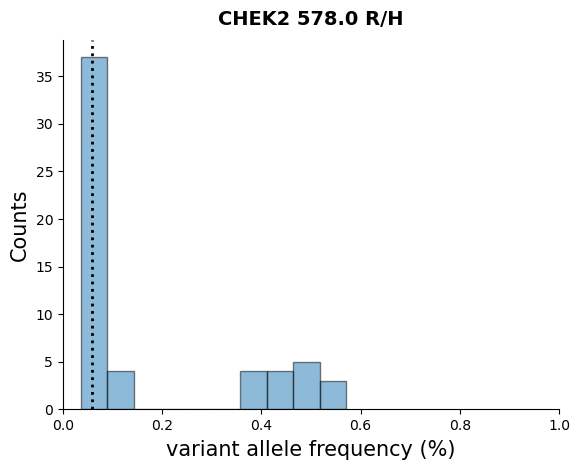

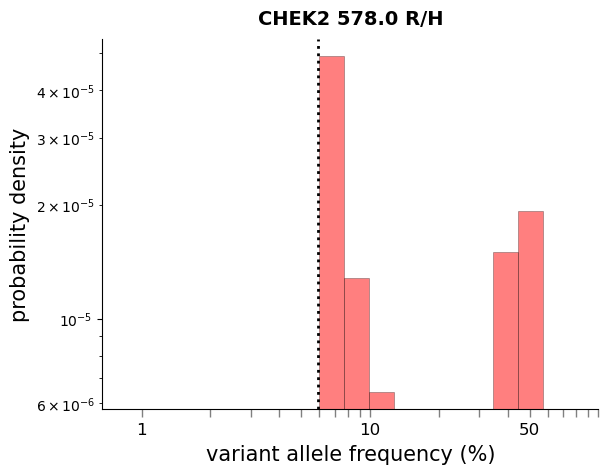

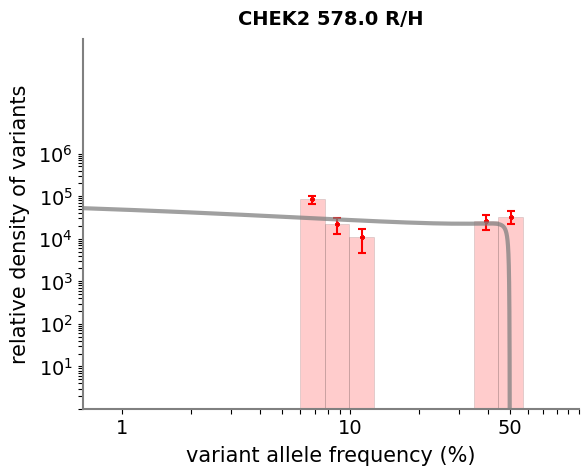

In [35]:
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats

mutations = []
mutation_ids = []
predicted_s =[]
num_trimmed_mut = []
predicted_mutrate_increase = []
boostDM_list = []
median_VAFs = []
prop_low_freqs = []
count_negatives = []
low_density_cutoffs= []
incomplete_densities= []

used_individuals_500k = 467202
binmethod = "doane"
scale = 1
multimodal_ids = {}
# SELECT A SINGLE MUTATION
for MUT_ID in tqdm(['22-28687925-T']):
    GENE_ID_all, mutation, boostDM = subset_mutation(MUT_ID) #subset mutation from the dataset
    GENE_ID_all_list = mut_dict2mut_list(GENE_ID_all)
    dat = np.array(GENE_ID_all_list)
    # sort data so returned indices are meaningful
    dat = np.msort(dat)
    
    f, ax1 = plt.subplots()
    GENE_ID_all_sorted = sorted(GENE_ID_all.items(), key=lambda x: x[1][1], reverse=True) #sort the results by VAF
    hist_data_VAF(dat, used_individuals_500k, binmethod, 'red', GENE_ID_all[next(iter(GENE_ID_all))][-1], limit_500k[mutation.split(' ')[0]], ax1)

    prop_low_freq = sum(pd.Series(GENE_ID_all_list) < 0.2)/len(GENE_ID_all_list) #calculate proportion of low-frequency mutations and if too low excude as potential germline
    median_VAFs.append(np.median(GENE_ID_all_list))
    prop_low_freqs.append(prop_low_freq)

    # Get the context to extract the hypothetical mutrate
    context = mutations_with_contexts[mutations_with_contexts['ID2'] == MUT_ID].iloc[0,-1]
    mut_with_context = context[0] + "[" + context[1] + ">" + MUT_ID.split("-")[2] + "]" + context[2]
    mutrate = dictionary_contexts[mut_with_context]

    #Get the limit
    GENE_ID_VAF_densities,GENE_ID_limit  = normalised_VAF_normalised_densities_list(GENE_ID_all_list, used_individuals_500k, mutrate, binmethod)
    GENE_ID_trimmed_list = trim_by_vaf(GENE_ID_all_list, limit_500k[mutation.split(' ')[0]])
    num_trimmed_mut.append(len(GENE_ID_trimmed_list))

    f, ax1 = plt.subplots()
    GENE_ID_trimmed_list_sorted = sorted(GENE_ID_trimmed_list, reverse=True) # Sort the results by VAF in descending order
    hist_data_for_plot_after(GENE_ID_trimmed_list_sorted, used_individuals_500k, binmethod, 'red', GENE_ID_all[next(iter(GENE_ID_all))][-1], limit_500k[mutation.split(' ')[0]], ax1)

    GENE_ID_VAF_densities_trimmed  = normalised_VAF_normalised_densities_list(GENE_ID_trimmed_list, used_individuals_500k, mutrate, binmethod)[0]
    GENE_ID_VAF_densities_trimmed_without_inf = exclude_inf(GENE_ID_VAF_densities_trimmed)

    if len(GENE_ID_VAF_densities_trimmed_without_inf) < len(GENE_ID_VAF_densities_trimmed):
        incomplete_densities.append(1)
    else:
        incomplete_densities.append(0)

    densities = [x[1] for x in GENE_ID_VAF_densities_trimmed_without_inf]
    count_negative = 0
    for i, density in enumerate(densities):
        if i < len(densities)-1:
            densities_inc = density-densities[i+1]
            if densities_inc < 0:
                count_negative += 1
            else:
                break  

    # check how many densities are below thershold
    densities = [x[0] for x in GENE_ID_VAF_densities]
    low_density_cutoff = []
    for density in densities:
        if density < np.log(limit_500k[mutation.split(' ')[0]]):
            low_density_cutoff.append(density)

    #scipy.optimize to determine s and inc_mut
    initial_guess=[0.13, 5] #[s, mutation_rate_increase]
    GENE_ID_values_results = scipy.optimize.minimize(logProbDataGivenModel_ages_mut_inc, initial_guess, args=(GENE_ID_VAF_densities_trimmed_without_inf,), method='Nelder-Mead')
    GENE_ID_s_val = GENE_ID_values_results.x[0]
    GENE_ID_mut_inc_val = GENE_ID_values_results.x[1]
#        print("Estimated s=" + str(GENE_ID_s_val))
    mutations.append(mutation)
    mutation_ids.append(MUT_ID)
    predicted_s.append(GENE_ID_s_val)
    predicted_mutrate_increase.append(GENE_ID_mut_inc_val)
    count_negatives.append(count_negative)
    low_density_cutoffs.append(len(low_density_cutoff))
    boostDM_list.append(boostDM)

    scale = 1
    f, (ax1) = plt.subplots()
    plot_log_hist_data_for_plot_solid_smaller(GENE_ID_trimmed_list, used_individuals_500k, mutrate*GENE_ID_mut_inc_val, binmethod, GENE_ID_all[next(iter(GENE_ID_all))][-1], \
                        'P', 2, "red", ax1)
    s=GENE_ID_s_val
    mut_inc = GENE_ID_mut_inc_val
    # Plot the line
    x1 = np.ndarray.tolist(np.linspace(-10, np.log(0.40), 100))
    x2 = np.ndarray.tolist(np.linspace(np.log(0.40), np.log(0.499999), 5000))
    x = x1+x2
    y =[logProbtheory_ages_mut_inc(l, [s, mut_inc]) for l in x]
    ax1.plot(x, y, c = "grey", alpha = 0.75, lw = 3)

# dictionary of lists 
result_dict = {'Mutation': mutations, 'Mutation_id': mutation_ids, 's': predicted_s, 'mutrate_increase':predicted_mutrate_increase,
               'num_trimmed_mut':num_trimmed_mut ,'median_VAFs':median_VAFs, 'prop_low_freqs':prop_low_freqs,"count_negatives":count_negatives,
               'low_density_cutoffs':low_density_cutoffs, 'incomplete_densities':incomplete_densities, "boostDM":boostDM_list} 
    
result_df = pd.DataFrame(result_dict)
result_df.head()

# 6. Final filtering

In [37]:
# Upload file with the fitness predictions generated above (NOT PROVIDED)
result_df2 = pd.read_csv('UK450k_mut_s_predictions_20230802_unique.csv')
result_df2.Drivers_12genes.value_counts()

0    248
1     95
Name: Drivers_12genes, dtype: int64

In [38]:
# Atypical distributions by visual inspection of the VAF distribution
atypical_list = ['ASXL1 394.0 R/H',
                 'ASXL1 1073.0 R/H',
                 'GNAS 659.0 K/T',
                 'DNMT3A 70.0 A/V',
                 'CHEK2 552.0 P/S',
                 'GNAS 844.0 R/H',
                 'GNAS 524.0 R/H',
                 'TET2 277.0 A/T',
                 'PPM1D 582.0 R/H',
                 'ASXL1 949.0 G/D',
                 'DNMT3A 55.0 R/H',
                 'TET2 1498.0 R/H'
                'CHEK2 387.0 I/L',
                'SF3B1 613.0 M/R',
                'GNAS 561.0 R/H',
                'IDH2 347.0 A/T',
                'ASXL1 134.0 A/T',
                'TP53 283.0 R/H']

In [40]:
# Removing possible germlines with median VAF higher than 0.3
a = result_df2[result_df2['median_VAFs']<0.3]
# Removing SNV 
a = a[~((a['normal_pvals']>=0.01))]
# Removing 8 SNV with a multimodal distribution 
a = a[a['multimodal_pvals']>0.2]
# Remove SNV that after trimming have less than 30 mut
a = a[a['num_trimmed_mut']>=30]
# Removing 3 SNV with higher s due to binomial distribution (checked by visual inspection of VAF distribution)
# All three non-drivers
a = a[a['s']<0.15]
a = a[~a['Mutation'].isin(atypical_list)]
a['Drivers_12genes'].value_counts()

1    65
0    20
Name: Drivers_12genes, dtype: int64

In [41]:
a.to_csv("UK450k_mut_s_predictions_20230802_unique_filtered.csv", index=False)

# Final plots

In [42]:
result_df2 = pd.read_csv('UK450k_mut_s_predictions_20230802_unique_filtered.csv')
result_df2

,Mutation,Mutation_id,s,mutrate_increase,num_trimmed_mut,median_VAFs,prop_low_freqs,count_negatives,low_density_cutoffs,incomplete_densities,multimodal_pvals,normal_pvals,ID2,boostDM_score,Drivers_12genes,SYMBOL
0,U2AF1 141.0 H/Y,21-43094716-A,0.045897,1114.829852,698,0.041667,1.000000,2,5,1,0.998002,2.518242e-55,21-43094716-A,0.129913,0,U2AF1
1,DNMT3A 882.0 R/H,2-25234373-T,0.089292,1.177998,808,0.074074,0.831243,1,2,0,1.000000,1.286152e-60,2-25234373-T,0.999207,1,DNMT3A
2,DNMT3A 882.0 R/C,2-25234374-A,0.090603,0.939107,526,0.068337,0.845614,0,2,0,1.000000,4.825632e-40,2-25234374-A,0.999008,1,DNMT3A
3,DNMT3A 735.0 Y/C,2-25240420-C,0.073699,17.233342,259,0.043989,0.966102,0,2,0,1.000000,1.329217e-55,2-25240420-C,0.998598,1,DNMT3A
4,DNMT3A 736.0 R/H,2-25240417-T,0.085440,0.270335,171,0.051503,0.915888,0,2,0,1.000000,1.852103e-26,2-25240417-T,0.993691,1,DNMT3A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,PPM1D 357.0 R/H,17-60656651-A,0.045771,6.307835,30,0.042254,1.000000,0,2,1,0.463536,4.876798e-04,17-60656651-A,0.001621,0,PPM1D
81,DNMT3A 550.0 G/R,2-25244559-T,0.076644,0.123114,31,0.056119,0.937500,1,0,1,0.998002,4.742079e-08,2-25244559-T,0.520581,1,DNMT3A
82,DNMT3A 525.0 A/V,2-25244633-A,0.060379,0.425220,31,0.050847,1.000000,0,1,0,0.871129,2.609682e-03,2-25244633-A,0.007468,0,DNMT3A
83,TET2 1366.0 R/H,4-105269662-A,0.098511,0.017656,32,0.070598,0.718750,0,0,1,0.673327,1.794604e-04,4-105269662-A,0.985957,1,TET2


(0.0, 0.16)

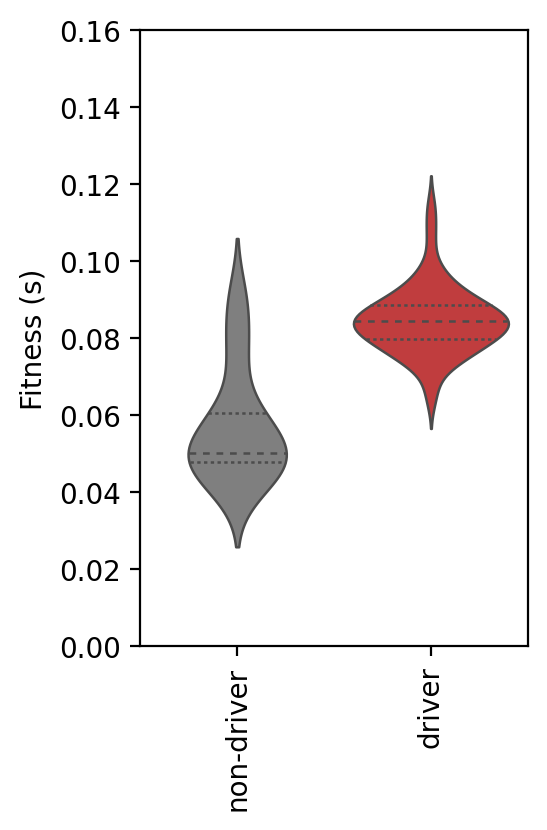

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.5, 4), dpi=200)

my_order = result_df2.groupby(by=["Drivers_12genes"])['s'].median().sort_values(ascending=True).index
sns.violinplot(data=result_df2, x="Drivers_12genes", y='s', inner='quartile', linewidth=0.9, palette=['tab:grey', '#D62728'], order=my_order)
# plt.scatter(driver_mut[driver_mut['VAF_alt']>=0.1]['SYMBOL'], driver_mut[driver_mut['VAF_alt']>=0.1]['VAF_alt'], alpha=0.4, color='#990707', s=1)
# plt.scatter(driver_mut[driver_mut['VAF_alt']<0.1]['SYMBOL'], driver_mut[driver_mut['VAF_alt']<0.1]['VAF_alt'], alpha=0.4, color='#EF6161', s=1)

plt.yticks(fontsize=10)
plt.xticks(range(2), ['non-driver', 'driver'], fontsize=10, rotation=90)
plt.xlabel('', fontsize=10)
plt.ylabel('Fitness (s)', fontsize=10)
plt.axhline(y=1, linewidth=0.8, linestyle='--', color='black')
plt.ylim(0, 0.16)

In [44]:
import scipy.stats as stats
from scipy.stats import ranksums
import statistics
group_driver = result_df2[result_df2['Drivers_12genes']==1]['s']
median_driver = np.nanmedian(group_driver.astype(float))
group_non = result_df2[result_df2['Drivers_12genes']==0]['s']
median_non = np.nanmedian(group_non.astype(float))
# # conduct the Wilcoxon-Signed Rank Test
pvalue = stats.mannwhitneyu(group_driver, group_non).pvalue
print('Driver:'+'{:.2e}'.format(median_driver)+' vs nondriver:'+'{:.2e}'.format(median_non)+'; pvalue='+'{:.2e}'.format(pvalue))

Driver:8.44e-02 vs nondriver:5.03e-02; pvalue=4.91e-08


In [45]:
series_name = ['nondriver', 'possnondriver', 'possdriver', 'driver']
color = ['#575757', '#939393', '#B65555', '#950A0A']
color_score = dict(zip(series_name, color))
color_score

series_name_simple = ['nondriver', 'driver']
color_simple = ['tab:grey', '#D62728']
color_score_simple = dict(zip(series_name_simple, color_simple))
color_score_simple

{'nondriver': 'tab:grey', 'driver': '#D62728'}

In [46]:
result_df2['Mutation_id'] = result_df2['Mutation_id'].str.replace('-', '_')
result_df2['Gene_mut'] = result_df2['Mutation'].apply(lambda x: x.split(' ')[0]+'-'+x[-3]+x.split(' ')[1][:-2]+x[-1])
result_df2

,Mutation,Mutation_id,s,mutrate_increase,num_trimmed_mut,median_VAFs,prop_low_freqs,count_negatives,low_density_cutoffs,incomplete_densities,multimodal_pvals,normal_pvals,ID2,boostDM_score,Drivers_12genes,SYMBOL,Gene_mut
0,U2AF1 141.0 H/Y,21_43094716_A,0.045897,1114.829852,698,0.041667,1.000000,2,5,1,0.998002,2.518242e-55,21-43094716-A,0.129913,0,U2AF1,U2AF1-H141Y
1,DNMT3A 882.0 R/H,2_25234373_T,0.089292,1.177998,808,0.074074,0.831243,1,2,0,1.000000,1.286152e-60,2-25234373-T,0.999207,1,DNMT3A,DNMT3A-R882H
2,DNMT3A 882.0 R/C,2_25234374_A,0.090603,0.939107,526,0.068337,0.845614,0,2,0,1.000000,4.825632e-40,2-25234374-A,0.999008,1,DNMT3A,DNMT3A-R882C
3,DNMT3A 735.0 Y/C,2_25240420_C,0.073699,17.233342,259,0.043989,0.966102,0,2,0,1.000000,1.329217e-55,2-25240420-C,0.998598,1,DNMT3A,DNMT3A-Y735C
4,DNMT3A 736.0 R/H,2_25240417_T,0.085440,0.270335,171,0.051503,0.915888,0,2,0,1.000000,1.852103e-26,2-25240417-T,0.993691,1,DNMT3A,DNMT3A-R736H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,PPM1D 357.0 R/H,17_60656651_A,0.045771,6.307835,30,0.042254,1.000000,0,2,1,0.463536,4.876798e-04,17-60656651-A,0.001621,0,PPM1D,PPM1D-R357H
81,DNMT3A 550.0 G/R,2_25244559_T,0.076644,0.123114,31,0.056119,0.937500,1,0,1,0.998002,4.742079e-08,2-25244559-T,0.520581,1,DNMT3A,DNMT3A-G550R
82,DNMT3A 525.0 A/V,2_25244633_A,0.060379,0.425220,31,0.050847,1.000000,0,1,0,0.871129,2.609682e-03,2-25244633-A,0.007468,0,DNMT3A,DNMT3A-A525V
83,TET2 1366.0 R/H,4_105269662_A,0.098511,0.017656,32,0.070598,0.718750,0,0,1,0.673327,1.794604e-04,4-105269662-A,0.985957,1,TET2,TET2-R1366H


In [48]:
# Upload SNV Age associations generated in the 3_Clinical_associations/Age_association_SNV.ipynb 
output = pd.read_csv('../3_Clinical_associations/output_Age_association_20230802.txt.gz',sep="\t")
output

,Mutation_id,num_mut,p_value,q_value,sig,odds_ratio,confint_1st,confint_2nd,pseudoR2,BDM_score,BDM_pred,BDM_pred_simple
0,21_43094716_A,883,9.529518e-01,9.948610e-01,ns,0.999752,0.991554,1.008018,0.001314,0.129913,possnondriver,nondriver
1,2_25234373_T,877,6.907319e-17,1.353834e-14,sig,1.038416,1.029267,1.047647,0.007683,0.999207,driver,driver
2,1_204538255_G,667,2.439289e-01,6.235932e-01,ns,0.994423,0.985111,1.003822,0.025839,0.052345,nondriver,nondriver
3,4_105272685_C,660,5.608813e-01,8.681582e-01,ns,0.997190,0.987779,1.006691,0.000841,0.385936,possnondriver,nondriver
4,2_25234374_A,570,4.658568e-16,6.087195e-14,sig,1.047600,1.035907,1.059425,0.010473,0.999008,driver,driver
...,...,...,...,...,...,...,...,...,...,...,...,...
387,2_25234367_A,30,6.953894e-01,9.075011e-01,ns,1.009065,0.964496,1.055694,0.016863,0.966625,driver,driver
388,20_32436374_A,30,7.399267e-01,9.236188e-01,ns,0.992620,0.950145,1.036995,0.154860,0.000013,nondriver,nondriver
389,17_60663341_A,30,5.320000e-02,2.343191e-01,ns,0.957475,0.916210,1.000600,0.058874,0.000038,nondriver,nondriver
390,22_28695827_C,30,3.253480e-01,7.142543e-01,ns,0.978247,0.936299,1.022074,0.033388,0.992880,driver,driver


In [50]:
# Merge them
df = pd.merge(result_df2, output,  how='inner', on='Mutation_id')
df

,Mutation,Mutation_id,s,mutrate_increase,num_trimmed_mut,median_VAFs,prop_low_freqs,count_negatives,low_density_cutoffs,incomplete_densities,...,p_value,q_value,sig,odds_ratio,confint_1st,confint_2nd,pseudoR2,BDM_score,BDM_pred,BDM_pred_simple
0,U2AF1 141.0 H/Y,21_43094716_A,0.045897,1114.829852,698,0.041667,1.000000,2,5,1,...,9.529518e-01,9.948610e-01,ns,0.999752,0.991554,1.008018,0.001314,0.129913,possnondriver,nondriver
1,DNMT3A 882.0 R/H,2_25234373_T,0.089292,1.177998,808,0.074074,0.831243,1,2,0,...,6.907319e-17,1.353834e-14,sig,1.038416,1.029267,1.047647,0.007683,0.999207,driver,driver
2,DNMT3A 882.0 R/C,2_25234374_A,0.090603,0.939107,526,0.068337,0.845614,0,2,0,...,4.658568e-16,6.087195e-14,sig,1.047600,1.035907,1.059425,0.010473,0.999008,driver,driver
3,DNMT3A 735.0 Y/C,2_25240420_C,0.073699,17.233342,259,0.043989,0.966102,0,2,0,...,3.695972e-20,1.448821e-17,sig,1.074383,1.058080,1.090938,0.021175,0.998598,driver,driver
4,DNMT3A 736.0 R/H,2_25240417_T,0.085440,0.270335,171,0.051503,0.915888,0,2,0,...,4.217213e-06,7.514307e-05,sig,1.043490,1.024735,1.062589,0.008230,0.993691,driver,driver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,PPM1D 357.0 R/H,17_60656651_A,0.045771,6.307835,30,0.042254,1.000000,0,2,1,...,4.866679e-01,8.294514e-01,ns,0.985203,0.944679,1.027466,0.014440,0.001621,nondriver,nondriver
81,DNMT3A 550.0 G/R,2_25244559_T,0.076644,0.123114,31,0.056119,0.937500,1,0,1,...,4.407337e-02,2.032560e-01,ns,1.049808,1.001291,1.100676,0.020660,0.520581,possdriver,driver
82,DNMT3A 525.0 A/V,2_25244633_A,0.060379,0.425220,31,0.050847,1.000000,0,1,0,...,3.304306e-02,1.682192e-01,ns,1.054106,1.004251,1.106435,0.023707,0.007468,nondriver,nondriver
83,TET2 1366.0 R/H,4_105269662_A,0.098511,0.017656,32,0.070598,0.718750,0,0,1,...,5.498003e-01,8.664830e-01,ns,0.987058,0.945808,1.030108,0.018245,0.985957,driver,driver


(0.0, 0.16)

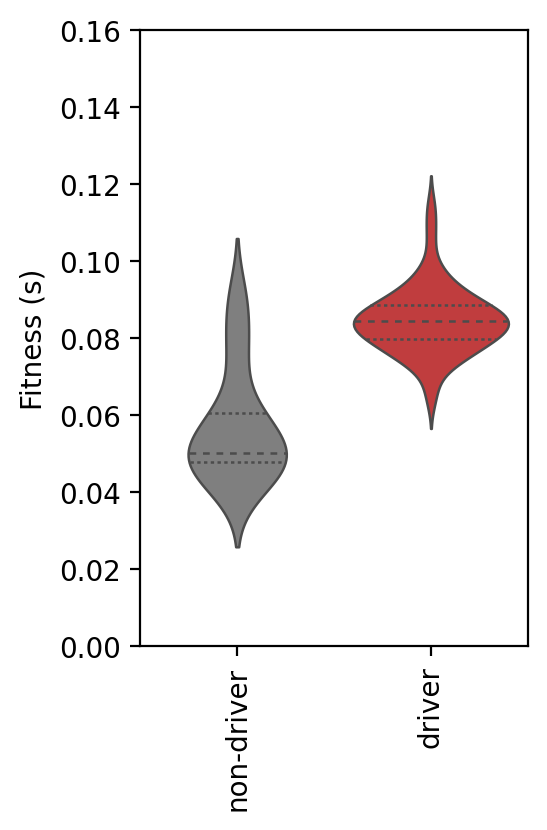

In [51]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.5, 4), dpi=200)

my_order = result_df2.groupby(by=["Drivers_12genes"])['s'].median().sort_values(ascending=True).index
sns.violinplot(data=result_df2, x="Drivers_12genes", y='s', inner='quartile', linewidth=0.9, palette=['tab:grey', '#D62728'], order=my_order)
# plt.scatter(driver_mut[driver_mut['VAF_alt']>=0.1]['SYMBOL'], driver_mut[driver_mut['VAF_alt']>=0.1]['VAF_alt'], alpha=0.4, color='#990707', s=1)
# plt.scatter(driver_mut[driver_mut['VAF_alt']<0.1]['SYMBOL'], driver_mut[driver_mut['VAF_alt']<0.1]['VAF_alt'], alpha=0.4, color='#EF6161', s=1)

plt.yticks(fontsize=10)
plt.xticks(range(2), ['non-driver', 'driver'], fontsize=10, rotation=90)
plt.xlabel('', fontsize=10)
plt.ylabel('Fitness (s)', fontsize=10)
plt.axhline(y=1, linewidth=0.8, linestyle='--', color='black')
plt.ylim(0, 0.16)

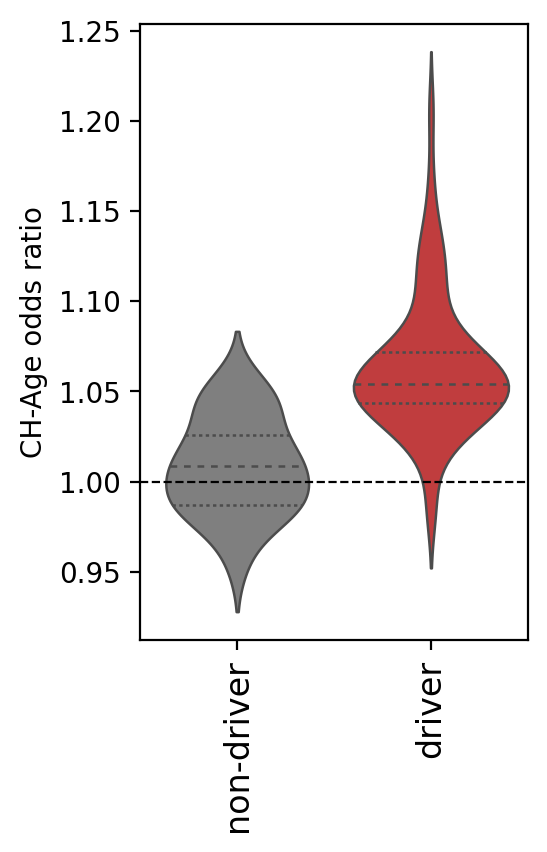

In [52]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.5, 4), dpi=200)

my_order = df.groupby(by=["Drivers_12genes"])['odds_ratio'].median().sort_values(ascending=True).index
sns.violinplot(data=df, x="Drivers_12genes", y='odds_ratio', inner='quartile', linewidth=0.9, palette=['tab:grey', '#D62728'], order=my_order)
# plt.scatter(driver_mut[driver_mut['VAF_alt']>=0.1]['SYMBOL'], driver_mut[driver_mut['VAF_alt']>=0.1]['VAF_alt'], alpha=0.4, color='#990707', s=1)
# plt.scatter(driver_mut[driver_mut['VAF_alt']<0.1]['SYMBOL'], driver_mut[driver_mut['VAF_alt']<0.1]['VAF_alt'], alpha=0.4, color='#EF6161', s=1)

plt.yticks(fontsize=10)
plt.xticks(range(2), ['non-driver', 'driver'], fontsize=12, rotation=90)
plt.xlabel('', fontsize=10)
plt.ylabel('CH-Age odds ratio', fontsize=10)
plt.axhline(y=1, linewidth=0.8, linestyle='--', color='black')
# plt.ylim(0.03, 0.15)

In [53]:
series_name = ['nondriver', 'possnondriver', 'possdriver', 'driver']
color = ['#575757', '#939393', '#B65555', '#950A0A']
color_score = dict(zip(series_name, color))
color_score

series_name_simple = [0, 1]
color_simple = ['tab:grey', '#D62728']
color_score_simple = dict(zip(series_name_simple, color_simple))
color_score_simple

{0: 'tab:grey', 1: '#D62728'}

/tmp/jobs/jramis/9874679/ipykernel_6148/3147952129.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df[df['Drivers_12genes']==0], x="s", y="odds_ratio",fill=False, bw_method='scott', bw_adjust=1, palette=color_score_simple, hue_order = ['driver', 'nondriver'], levels=10, cmap="Greys", ax=g.ax_joint)
/tmp/jobs/jramis/9874679/ipykernel_6148/3147952129.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df[df['Drivers_12genes']==1], x="s", y="odds_ratio", fill=False, bw_method='scott', bw_adjust=1, palette=color_score_simple, hue_order = ['driver', 'nondriver'], levels=10, cmap="Reds", ax=g.ax_joint)
/tmp/jobs/jramis/9874679/ipykernel_6148/3147952129.py:11: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(df[df['BDM_pred_simple']=='driver'].odds_ratio, color="tab:red", ax=g.

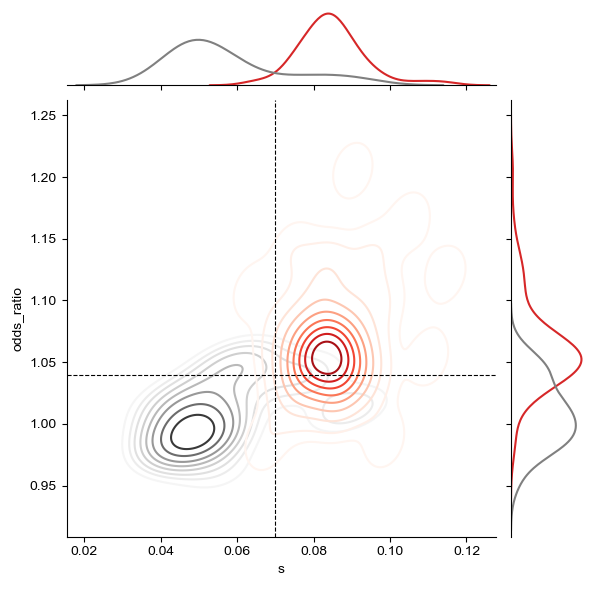

In [54]:
g = sns.JointGrid(x="s", y="odds_ratio", data=df)

sns.set_style(rc = {'axes.facecolor': 'white'})
sns.set_style("ticks")
sns.kdeplot(data=df[df['Drivers_12genes']==0], x="s", y="odds_ratio",fill=False, bw_method='scott', bw_adjust=1, palette=color_score_simple, hue_order = ['driver', 'nondriver'], levels=10, cmap="Greys", ax=g.ax_joint)
sns.kdeplot(data=df[df['Drivers_12genes']==1], x="s", y="odds_ratio", fill=False, bw_method='scott', bw_adjust=1, palette=color_score_simple, hue_order = ['driver', 'nondriver'], levels=10, cmap="Reds", ax=g.ax_joint)
plt.xlabel('Fitness (s)')
plt.ylabel('CH-Age Odds Ratio')
sns.kdeplot(df[df['BDM_pred_simple']=='driver'].s, color="tab:red", ax=g.ax_marg_x)
sns.kdeplot(df[df['BDM_pred_simple']=='nondriver'].s, color="grey", ax=g.ax_marg_x)
sns.kdeplot(df[df['BDM_pred_simple']=='driver'].odds_ratio, color="tab:red", ax=g.ax_marg_y, vertical=True)
sns.kdeplot(df[df['BDM_pred_simple']=='nondriver'].odds_ratio, color="grey", ax=g.ax_marg_y, vertical=True)
g.ax_joint.axhline(y=1.04, linewidth=0.8, linestyle='--', color='black')
g.ax_joint.axvline(x=0.07, linewidth=0.8, linestyle='--', color='black')

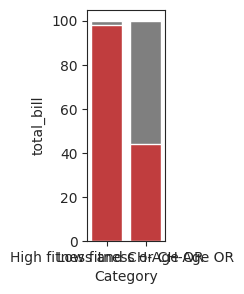

In [84]:
# import libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# load dataset
tips = sns.load_dataset("tips")

# set the figure size
plt.figure(figsize=(1, 3))

# from raw value to percentage
total = pd.DataFrame([['High fitness and CH-Age OR', len(df[(df['odds_ratio']>=1.04)&(df['s']>=0.07)])],
                      ['Low fitness or CH-Age OR', len(df[(df['odds_ratio']<1.04)|(df['s']<0.07)])]], columns =['Category', 'total_bill'])

                       
drivers = pd.DataFrame([['High fitness and CH-Age OR', len(df[(df['odds_ratio']>=1.04)&(df['s']>=0.07)&(df['BDM_pred_simple']=='driver')])],
                      ['Low fitness or CH-Age OR', len(df[((df['odds_ratio']<1.04)|(df['s']<0.07))&(df['BDM_pred_simple']=='driver')])]], columns =['Category', 'total_bill'])
drivers['total_bill'] = [i / j * 100 for i,j in zip(drivers['total_bill'], total['total_bill'])]
total['total_bill'] = [i / j * 100 for i,j in zip(total['total_bill'], total['total_bill'])]

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="Category",  y="total_bill", data=total, color='tab:grey')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="Category", y="total_bill", data=drivers, color='#D62728')

# add legend
top_bar = mpatches.Patch(color='#D62728', label='High fitness and CH-Age OR')
bottom_bar = mpatches.Patch(color='tab:grey', label='Low fitness or CH-Age OR')

# show the graph
plt.show()